In [35]:
from imports import *
import random

In [36]:
def load_pose_data(pose_df_path, mappings):
    df = pd.read_excel(pose_df_path, index_col=0)
    df.rename(columns=mappings, inplace=True)
    fps = df['fps'].values[0]
    return df, fps

def get_normalised_kepoints(aggregated_pose_df):
    norm_df = bbox_normalize_joint_coordinates(aggregated_pose_df[[joint + '_x' for joint in joints] + [joint + '_y' for joint in joints]].copy())
    # Normalise the keypoints
    normalised_keypoints_y = np.array([norm_df[joint + '_y_normalized'].values for joint in joints])
    normalised_keypoints_x = np.array([norm_df[joint + '_x_normalized'].values for joint in joints])
    normalised_keypoints_all = np.concatenate([normalised_keypoints_x, normalised_keypoints_y], axis=0)
    return normalised_keypoints_all.T, normalised_keypoints_x.T, normalised_keypoints_y.T

def get_breakpoints(normalised_keypoints, num_phases):
    bkpts_algorithm = rpt.KernelCPD(kernel="rbf", min_size=5)
    bkpts = bkpts_algorithm.fit_predict(normalised_keypoints, n_bkps=num_phases - 1)
    return bkpts

def preprocess(df):
    df['mid_hip_x'] = (df['left_hip_x'] + df['right_hip_x']) / 2
    df['mid_hip_y'] = (df['left_hip_y'] + df['right_hip_y']) / 2
    df['mid_shoulder_x'] = (df['left_shoulder_x'] + df['right_shoulder_x']) / 2
    df['mid_shoulder_y'] = (df['left_shoulder_y'] + df['right_shoulder_y']) / 2

    df.drop(columns=[
                    'ball_position_x', 'ball_position_y',
                    'right_eye_x', 'right_eye_y', 'left_eye_x', 'left_eye_y',
                    'right_ear_x', 'right_ear_y', 'left_ear_x', 'left_ear_y', 'min_wrist_y'], inplace=True)
    return df

In [37]:
random.seed(0)

joints = [
    'right_shoulder', 'right_elbow', 'right_wrist', 
    'nose', 
    'left_shoulder', 'left_elbow', 'left_wrist', 
    'right_hip', 'right_knee', 'right_ankle', 
    'left_hip', 'left_knee', 'left_ankle'
    ]

phase_colors = {'run-up': 'lightblue', 'jump': 'lightgreen', 'attack': 'lightpink', 'landing': 'wheat'}

# get random 2 files + reference
reference = 'Techniek_aanval_met_sprong_Ref_POSE_tabel.xlsx'
files = random.sample(os.listdir(EXCEL_DATA_DIR), 2)
files += [reference]
files

['GX010054_Clip_196_POSE_tabel.xlsx',
 'GX010040_Clip_2_sec_6_POSE_tabel.xlsx',
 'Techniek_aanval_met_sprong_Ref_POSE_tabel.xlsx']

/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_19422/2428523622.py:71: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_19422/2428523622.py:71: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


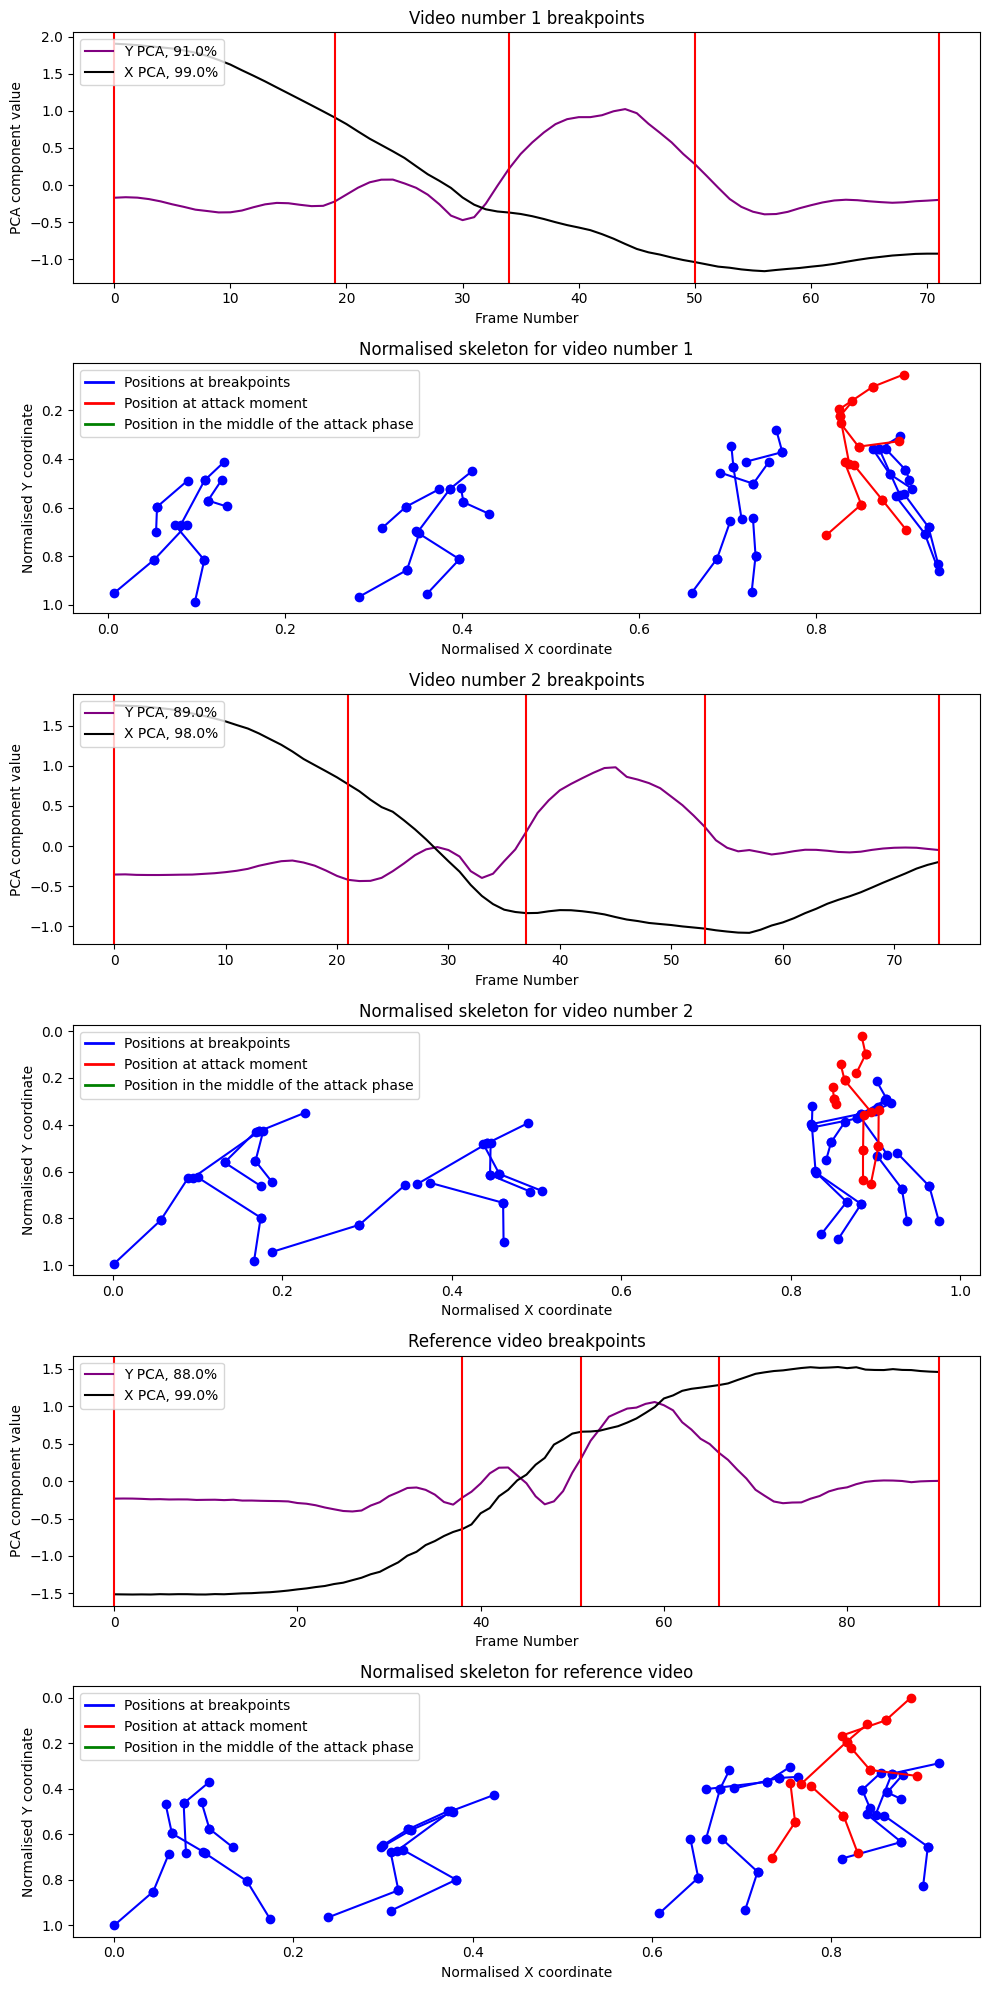

In [39]:
from matplotlib.lines import Line2D

legend_elements = [
                Line2D([0], [0], color='b', lw=2, label='Positions at breakpoints'),
                Line2D([0], [0], color='r', lw=2, label='Position at attack moment'),
                Line2D([0], [0], color='g', lw=2, label='Position in the middle of the attack phase')
                ]

fig, ax = plt.subplots(len(files) * 2, 1, figsize=(10, 20))

for i, file in enumerate(files):
    ref_fps = 24
    NUM_PHASES = 4

    df, fps = load_pose_data(EXCEL_DATA_DIR + file, MAPPINGS)

    df = preprocess(df)
    
    attack = np.mean(df[df.phase == 'attack'].index)

    agg_df, indices = aggregate_all_numeric_columns(df, fps, ref_fps)
    df_norm, x_norm, y_norm = get_normalised_kepoints(agg_df)
    agg_norm_df = bbox_normalize_joint_coordinates(agg_df)
    bkpts = get_breakpoints(df_norm, NUM_PHASES)

    pca_y = PCA(n_components=1)
    Y = pca_y.fit_transform(y_norm)
    var_y = round(pca_y.explained_variance_ratio_[0], 2) * 100

    pca_x = PCA(n_components=1)
    X = pca_x.fit_transform(x_norm)
    var_x = round(pca_x.explained_variance_ratio_[0], 2) * 100

    if file != reference:
        ax[2*i].set_title(f'Video number {i + 1} breakpoints')
    else:
        ax[2*i].set_title('Reference video breakpoints')

    ax[2*i].plot(Y, label=f'Y PCA, {var_y}%', color='purple')
    ax[2*i].plot(X, label=f'X PCA, {var_x}%', color='black')

    ax[2*i].set_ylabel('PCA component value')
    ax[2*i].set_xlabel('Frame Number')

    mid_3_bkpt = (bkpts[1] + bkpts[2]) // 2
    attack_frame = int(indices[0][int(attack)])

    for bkp in [0] + bkpts[:-1]:
        ax[2*i].axvline(bkp, color='r')
        plot_sequence(agg_norm_df, bkp, normalised=True, ax=ax[2*i + 1], color='b')
    ax[2*i].axvline(bkpts[-1] - 1, color='r')    

    # plot_sequence(agg_norm_df, mid_3_bkpt, normalised=True, ax=ax[2*i + 1], color='green')
    plot_sequence(agg_norm_df, attack_frame, normalised=True, ax=ax[2*i + 1], color='red')

    ax[2*i].legend(loc='upper left')

    # ax[2*i + 1].invert_yaxis()

    if file != reference:
        ax[2*i + 1].set_title(f'Normalised skeleton for video number {i + 1}')
    else:
        ax[2*i + 1].set_title('Normalised skeleton for reference video')

    ax[2*i + 1].set_xlabel('Normalised X coordinate')
    ax[2*i + 1].set_ylabel('Normalised Y coordinate')

    # Create the figure
    ax[2*i + 1].legend(handles=legend_elements, loc='upper left')

    fig.tight_layout()



In [9]:
files

['GX010054_Clip_196_POSE_tabel.xlsx',
 'GX010040_Clip_2_sec_6_POSE_tabel.xlsx',
 'Techniek_aanval_met_sprong_Ref_POSE_tabel.xlsx']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


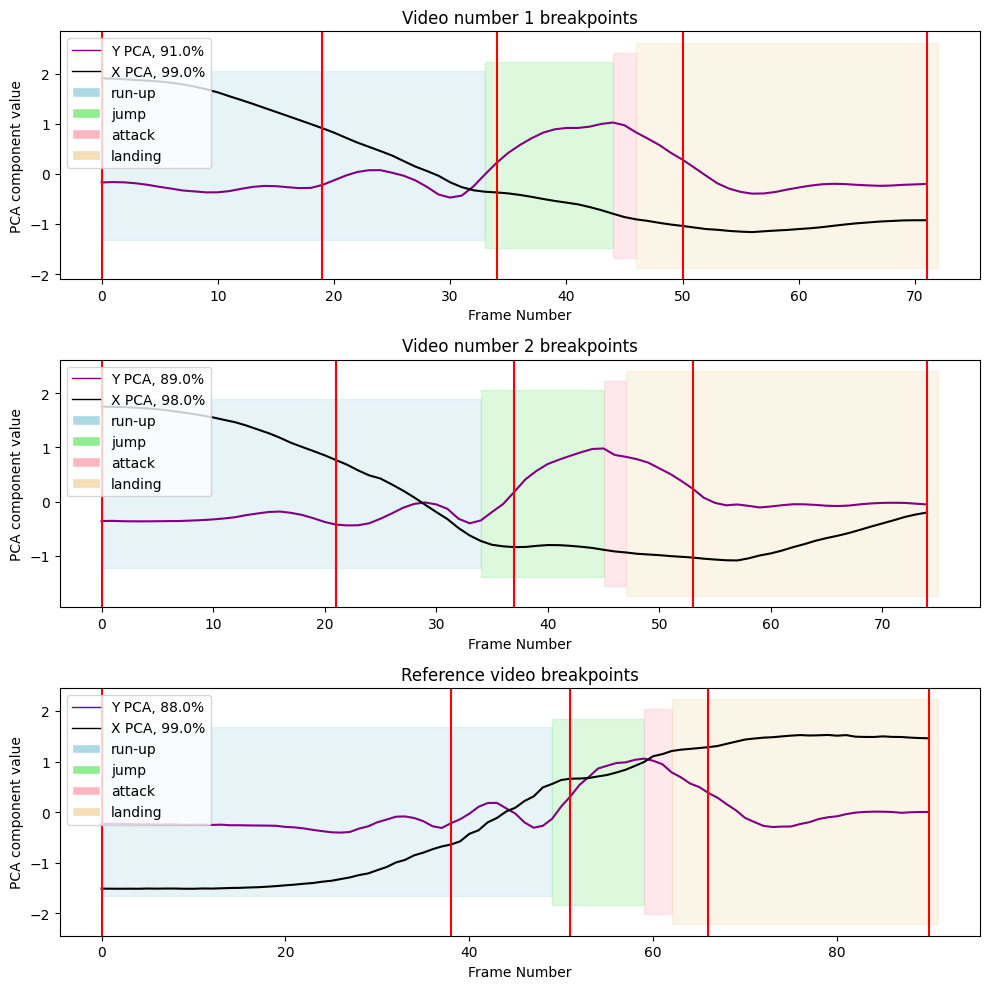

In [10]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

phase_colors = {'run-up': 'lightblue', 'jump': 'lightgreen', 'attack': 'lightpink', 'landing': 'wheat'}

fig, ax = plt.subplots(len(files), 1, figsize=(10, 10))

for i, file in enumerate(files):
    ref_fps = 24
    NUM_PHASES = 4

    df, fps = load_pose_data(EXCEL_DATA_DIR + file, MAPPINGS)

    if file != 'Techniek_aanval_met_sprong_Ref_POSE_tabel.xlsx':
        phase_col = aggregate_phases(df, fps, 24)
    else:
        phase_col = df['phase']

    df = preprocess(df)
    
    # attack = np.mean(df[df.phase == 'attack'].index)
    phase_col = aggregate_phases(df, fps, 24)
    agg_df, indices = aggregate_all_numeric_columns(df, fps, ref_fps)
    df_norm, x_norm, y_norm = get_normalised_kepoints(agg_df)
    agg_norm_df = bbox_normalize_joint_coordinates(agg_df)
    bkpts = get_breakpoints(df_norm, NUM_PHASES)

    pca_y = PCA(n_components=1)
    Y = pca_y.fit_transform(y_norm)
    var_y = round(pca_y.explained_variance_ratio_[0], 2) * 100

    pca_x = PCA(n_components=1)
    X = pca_x.fit_transform(x_norm)
    var_x = round(pca_x.explained_variance_ratio_[0], 2) * 100

    if file != reference:
        ax[i].set_title(f'Video number {i + 1} breakpoints')
    else:
        ax[i].set_title('Reference video breakpoints')

    ax[i].plot(Y, color='purple')
    ax[i].plot(X, color='black')

    ax[i].set_ylabel('PCA component value')
    ax[i].set_xlabel('Frame Number')

    # attack_frame = int(indices[0][int(attack)])

    for bkp in [0] + bkpts[:-1]:
        ax[i].axvline(bkp, color='r')
    ax[i].axvline(bkpts[-1] - 1, color='r')    

    ax[i].legend(loc='upper left')

    # plot automatic phases
    start_idx = 0
    current_phase = phase_col[0]
    for idx, phase in enumerate(phase_col):
        if phase != current_phase or idx == len(phase_col) - 1:
            end_idx = idx if phase != current_phase else len(phase_col)
            ax[i].fill_betweenx(ax[i].get_ylim(), start_idx, end_idx, color=phase_colors[current_phase], alpha=0.3)
            start_idx = idx
            current_phase = phase

    legend_elements = [
                Line2D([0], [0], color='purple', lw=1, label=f'Y PCA, {var_y}%'),
                Line2D([0], [0], color='black', lw=1, label=f'X PCA, {var_x}%'),
                Patch(facecolor='lightblue', edgecolor='white', label='run-up'),
                Patch(facecolor='lightgreen', edgecolor='white', label='jump'),
                Patch(facecolor='lightpink', edgecolor='white', label='attack'),
                Patch(facecolor='wheat', edgecolor='white', label='landing'),
                ]
    
    ax[i].legend(handles=legend_elements, loc='upper left')

fig.tight_layout()



In [39]:
sep_points_all = []
sep_points_all_attack_normalised = []
attack_in_3rd_phase = []

for filename in os.listdir(EXCEL_DATA_DIR):
    df, fps = load_pose_data(EXCEL_DATA_DIR + filename, MAPPINGS)
    df = preprocess(df)
    agg_df, indices = aggregate_all_numeric_columns(df, fps, ref_fps)
    if len(agg_df) > 100:
        print(filename, len(agg_df), len(df))
    df_norm, x_norm, y_norm = get_normalised_kepoints(agg_df)
    agg_norm_df = bbox_normalize_joint_coordinates(agg_df)
    bkpts = get_breakpoints(df_norm, NUM_PHASES)
    attack = int(indices[0][int(np.mean(df[df.phase == 'attack'].index))])

    attack_in_3rd_phase.append(attack > bkpts[1] and attack < bkpts[2])

    sep_points_all.extend([bkp for bkp in bkpts][:-1])
    sep_points_all_attack_normalised.extend([bkp - attack for bkp in bkpts][:-1])


Vollley_Jakub_01_POSE_tabel.xlsx 127 318


In [57]:
sep_points_1 = sep_points_all[0::3]
sep_points_2 = sep_points_all[1::3]
sep_points_3 = sep_points_all[2::3]
sep_points_all_attack_normalised_1 = sep_points_all_attack_normalised[::3]
sep_points_all_attack_normalised_2 = sep_points_all_attack_normalised[1::3]
sep_points_all_attack_normalised_3 = sep_points_all_attack_normalised[2::3]

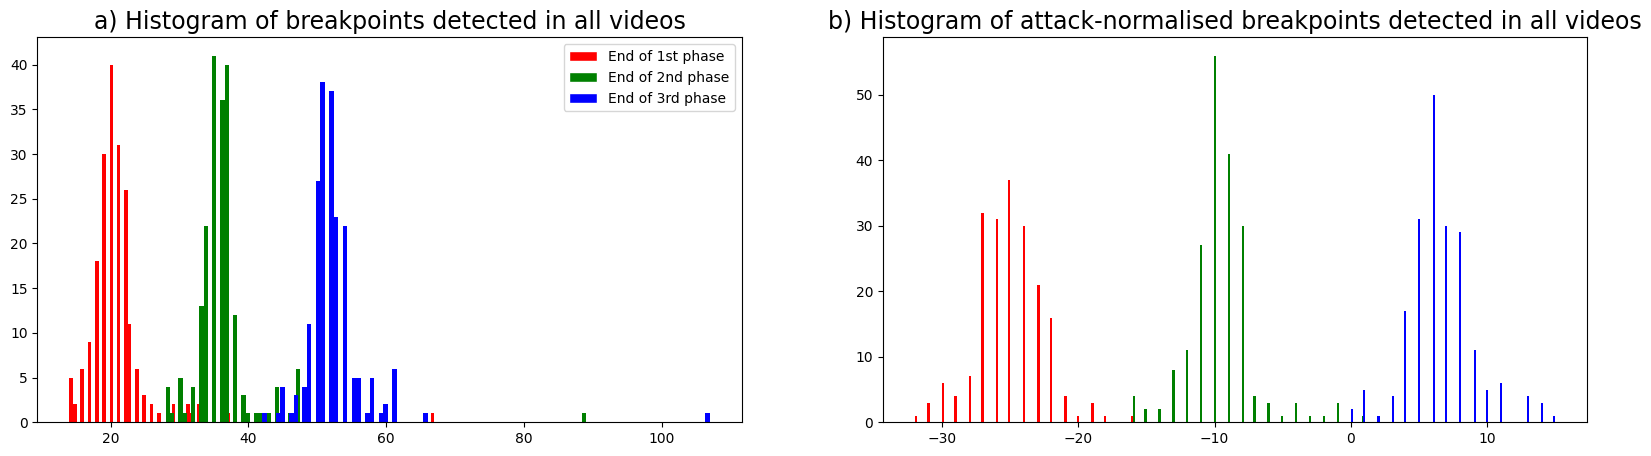

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].hist(sep_points_1, bins=100, color='r')
ax[0].hist(sep_points_2, bins=100, color='g')
ax[0].hist(sep_points_3, bins=100, color='b')

ax[1].hist(sep_points_all_attack_normalised_1, bins=100, color='r')
ax[1].hist(sep_points_all_attack_normalised_2, bins=100, color='g')
ax[1].hist(sep_points_all_attack_normalised_3, bins=100, color='b')

ax[0].set_title('a) Histogram of breakpoints detected in all videos', fontsize=17)
ax[1].set_title('b) Histogram of attack-normalised breakpoints detected in all videos', fontsize=17)

legend_elements = [
                Patch(facecolor='r', edgecolor='white', label='End of 1st phase'),
                Patch(facecolor='g', edgecolor='white', label='End of 2nd phase'),
                Patch(facecolor='b', edgecolor='white', label='End of 3rd phase'),
                ]
    
ax[0].legend(handles=legend_elements, loc='upper right')

plt.show()

In [68]:
round(sum(attack_in_3rd_phase) / len(attack_in_3rd_phase), 4) * 100

97.99

bad breakpoints

In [30]:
bad_files = [
     'GX010053_Clip_29_POSE_tabel.xlsx',
     'Vollley_Jakub_01_POSE_tabel.xlsx'
]

# bad_files += [reference]

In [31]:
bad_files

['GX010053_Clip_29_POSE_tabel.xlsx', 'Vollley_Jakub_01_POSE_tabel.xlsx']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


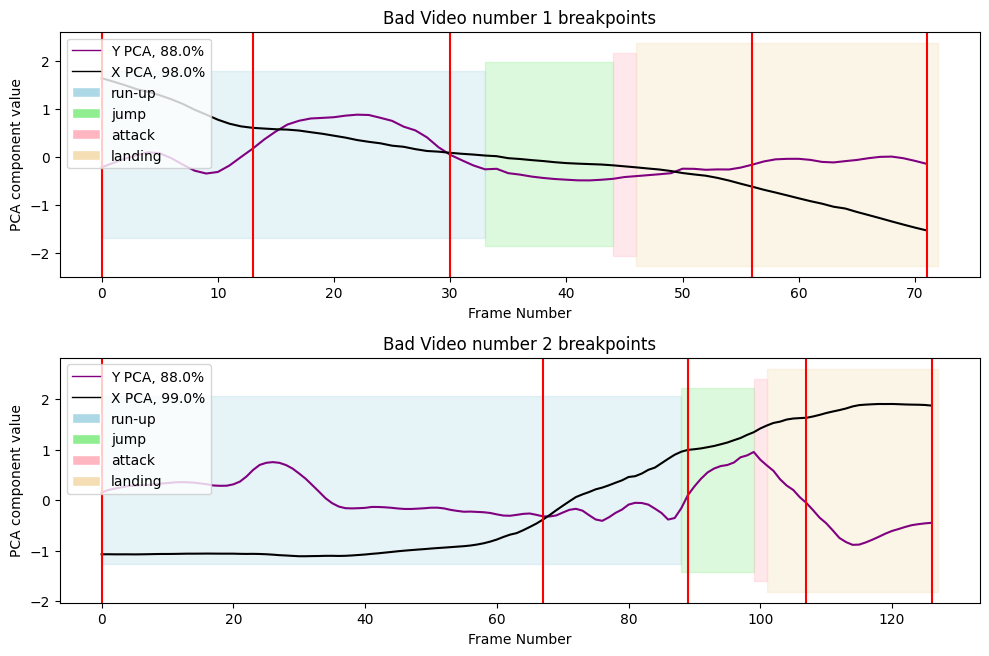

In [34]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

phase_colors = {'run-up': 'lightblue', 'jump': 'lightgreen', 'attack': 'lightpink', 'landing': 'wheat'}

fig, ax = plt.subplots(len(bad_files), 1, figsize=(10, 6.666666))

for i, file in enumerate(bad_files):
    ref_fps = 24
    NUM_PHASES = 4

    df, fps = load_pose_data(EXCEL_DATA_DIR + file, MAPPINGS)

    if file != 'Techniek_aanval_met_sprong_Ref_POSE_tabel.xlsx':
        phase_col = aggregate_phases(df, fps, 24)
    else:
        phase_col = df['phase']

    df = preprocess(df)
    
    # attack = np.mean(df[df.phase == 'attack'].index)
    phase_col = aggregate_phases(df, fps, 24)
    agg_df, indices = aggregate_all_numeric_columns(df, fps, ref_fps)
    df_norm, x_norm, y_norm = get_normalised_kepoints(agg_df)
    agg_norm_df = bbox_normalize_joint_coordinates(agg_df)
    bkpts = get_breakpoints(df_norm, NUM_PHASES)

    pca_y = PCA(n_components=1)
    Y = pca_y.fit_transform(y_norm)
    var_y = round(pca_y.explained_variance_ratio_[0], 2) * 100

    pca_x = PCA(n_components=1)
    X = pca_x.fit_transform(x_norm)
    var_x = round(pca_x.explained_variance_ratio_[0], 2) * 100

    if file != reference:
        ax[i].set_title(f'Bad Video number {i + 1} breakpoints')
    else:
        ax[i].set_title('Reference video breakpoints')

    ax[i].plot(Y, color='purple')
    ax[i].plot(X, color='black')

    ax[i].set_ylabel('PCA component value')
    ax[i].set_xlabel('Frame Number')

    for bkp in [0] + bkpts[:-1]:
        ax[i].axvline(bkp, color='r')
    ax[i].axvline(bkpts[-1] - 1, color='r')    

    ax[i].legend(loc='upper left')

    # plot automatic phases
    start_idx = 0
    current_phase = phase_col[0]
    for idx, phase in enumerate(phase_col):
        if phase != current_phase or idx == len(phase_col) - 1:
            end_idx = idx if phase != current_phase else len(phase_col)
            ax[i].fill_betweenx(ax[i].get_ylim(), start_idx, end_idx, color=phase_colors[current_phase], alpha=0.3)
            start_idx = idx
            current_phase = phase

    legend_elements = [
                Line2D([0], [0], color='purple', lw=1, label=f'Y PCA, {var_y}%'),
                Line2D([0], [0], color='black', lw=1, label=f'X PCA, {var_x}%'),
                Patch(facecolor='lightblue', edgecolor='white', label='run-up'),
                Patch(facecolor='lightgreen', edgecolor='white', label='jump'),
                Patch(facecolor='lightpink', edgecolor='white', label='attack'),
                Patch(facecolor='wheat', edgecolor='white', label='landing'),
                ]
    
    ax[i].legend(handles=legend_elements, loc='upper left')

fig.tight_layout()